## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

In [2]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [3]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

In [4]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [16]:
from deepmeg.models import BaseModel
import torch.nn as nn

class TS(nn.Module):
    def __init__(self, n_channels, n_times):
        super().__init__()
        self.n_channels = n_channels
        self.n_times = n_times
        self.i = nn.Parameter(torch.empty(self.n_times, self.n_channels))
        self.b = nn.Parameter(torch.empty(1, self.n_times))
        self.d = nn.Dropout(.5)
        self.reset_parameters()
        self.x_prev = 0

    def reset_parameters(self) -> None:
        nn.init.uniform_(self.i, -0.01, 0.01)
        nn.init.uniform_(self.b, -0.01, 0.01)
        # init.uniform_(self.s, -0.01, 0.01)

    def forward(self, x):
        out = torch.zeros(x.shape[0], self.n_times)
        for i in range(self.n_times):
            timepoint = x[:, :, i]
            # print(timepoint.shape)
            # sp_filter = self.i[i]@self.s
            out[:, i] = self.i[i]@timepoint.T

        return self.d(out + self.b)


class TSUnmixer(nn.Module):
    def __init__(self, n_channels, n_times, n_latent):
        super().__init__()
        self.unmixers = nn.ModuleList([TS(n_channels, n_times) for _ in range(n_latent)])
    def forward(self, x):
        out = list()
        for unmixer in self.unmixers:
            out.append(unmixer(x))
        return torch.stack(out, 1)


class TSNet(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        # self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.unmixing_layer = TSUnmixer(n_channels, n_times, n_latent)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [246]:
class TSNetSep(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        # self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.unmixing_layer = TSUnmixer(n_channels, n_times, n_latent)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.ModuleList([nn.Linear(final_out_features, 1) for _ in range(n_outputs)])


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        out = torch.cat([fc(x) for fc in self.fc_layer], -1)
        return out

In [387]:
class LFCNNSep(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        # self.unmixing_layer = TSUnmixer(n_channels, n_times, n_latent)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.ModuleList([nn.Linear(final_out_features, 1) for _ in range(n_outputs)])


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        out = torch.cat([fc(x) for fc in self.fc_layer], -1)
        return out

In [239]:
X, y = next(iter(DataLoader(train, 2)))

In [8]:
X.shape

torch.Size([2, 204, 301])

In [388]:
LFCNNSep(
    n_channels=X.shape[1], # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[2], # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)(X).shape

torch.Size([2, 8])

In [393]:
model = LFCNNSep(
    n_channels=X.shape[1], # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=X.shape[2], # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
                # *[f'unmixing_layer.unmixers.{i}.i' for i in range(8)]
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [392]:
sys.stdout = sys.stdout.file

In [394]:
list(model.state_dict().keys())

['unmixing_layer.weight',
 'unmixing_layer.bias',
 'temp_conv.weight',
 'temp_conv.bias',
 'fc_layer.0.weight',
 'fc_layer.0.bias',
 'fc_layer.1.weight',
 'fc_layer.1.bias',
 'fc_layer.2.weight',
 'fc_layer.2.bias',
 'fc_layer.3.weight',
 'fc_layer.3.bias',
 'fc_layer.4.weight',
 'fc_layer.4.bias',
 'fc_layer.5.weight',
 'fc_layer.5.bias',
 'fc_layer.6.weight',
 'fc_layer.6.bias',
 'fc_layer.7.weight',
 'fc_layer.7.bias']

## Training the model

Epoch 0:  loss_train:  0.7175   |    binary_accuracy_train:  0.5566   |    loss_val:  0.7030   |    binary_accuracy_val:  0.6195
Epoch 1:  loss_train:  0.6927   |    binary_accuracy_train:  0.6702   |    loss_val:  0.6796   |    binary_accuracy_val:  0.7183
Epoch 2:  loss_train:  0.6671   |    binary_accuracy_train:  0.7595   |    loss_val:  0.6541   |    binary_accuracy_val:  0.7810
Epoch 3:  loss_train:  0.6379   |    binary_accuracy_train:  0.8158   |    loss_val:  0.6256   |    binary_accuracy_val:  0.8174
Epoch 4:  loss_train:  0.6043   |    binary_accuracy_train:  0.8457   |    loss_val:  0.5939   |    binary_accuracy_val:  0.8354
Epoch 5:  loss_train:  0.5667   |    binary_accuracy_train:  0.8540   |    loss_val:  0.5599   |    binary_accuracy_val:  0.8491
Epoch 6:  loss_train:  0.5276   |    binary_accuracy_train:  0.8591   |    loss_val:  0.5262   |    binary_accuracy_val:  0.8456
Epoch 7:  loss_train:  0.4913   |    binary_accuracy_train:  0.8611   |    loss_val:  0.4955   | 

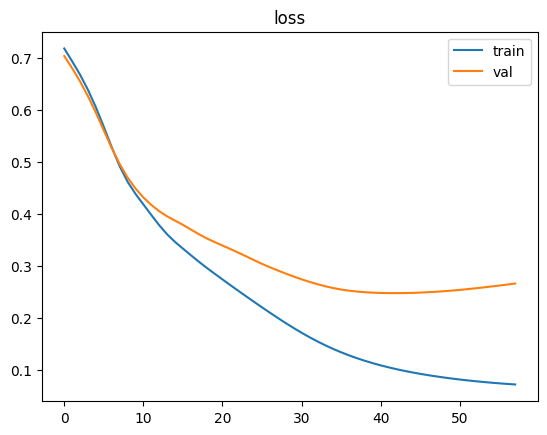

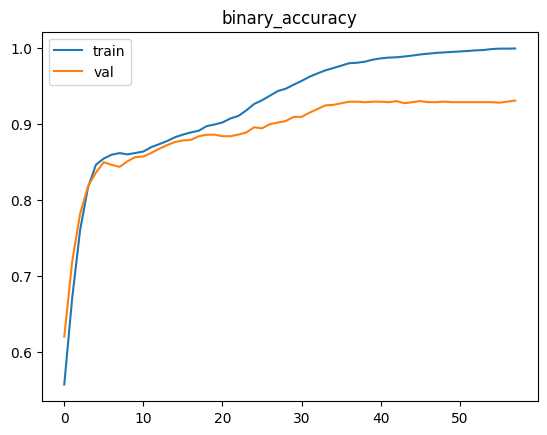

In [395]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [396]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1302544115619226
train_binary_accuracy: 0.9751529693603516
loss: 0.21966413408517838
binary_accuracy: 0.9383116852153431


## Make a prediction

In [399]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Sample 126
Prediction: -6.46 | -5.74 | -9.15 |  1.82 | -6.12 | -5.59 | -8.23 | -4.23
Actual:      0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0  |  0.0  |  0.0 


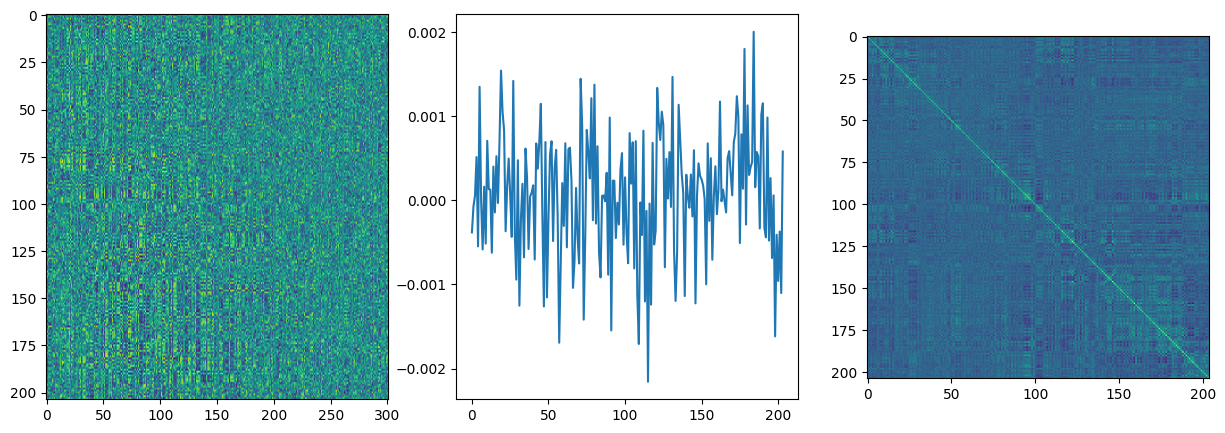

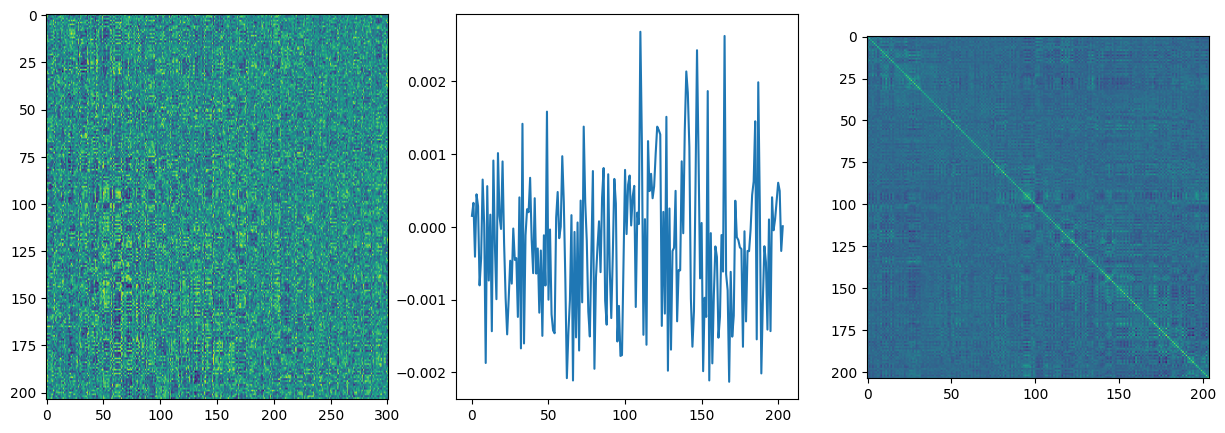

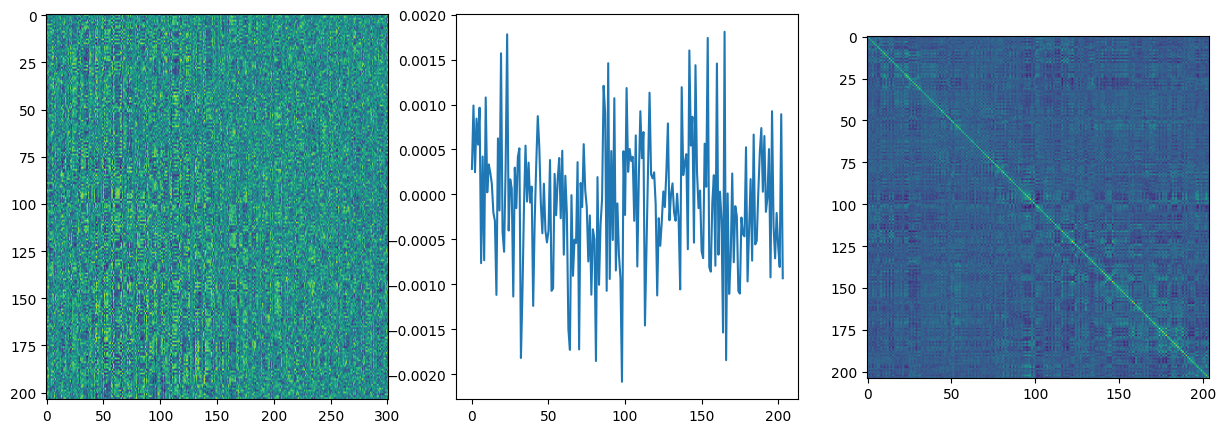

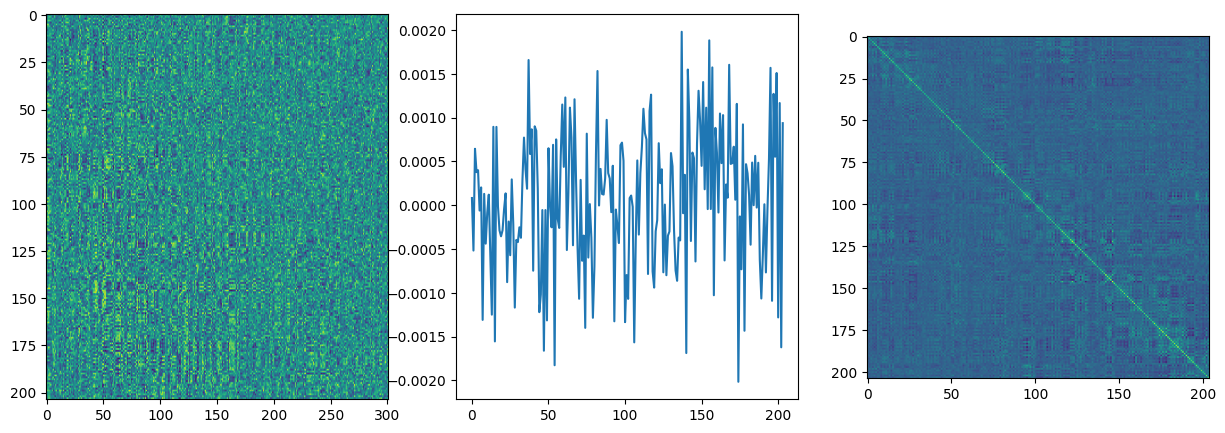

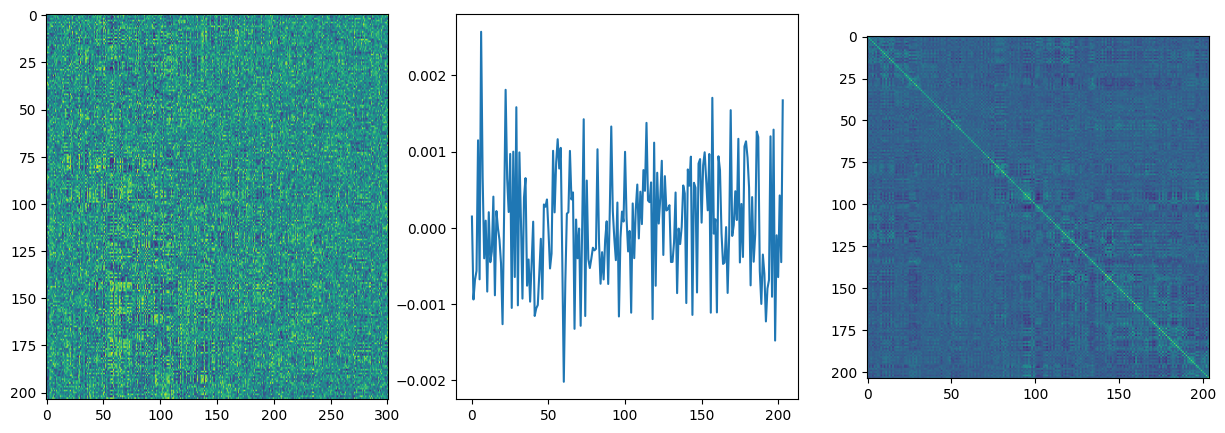

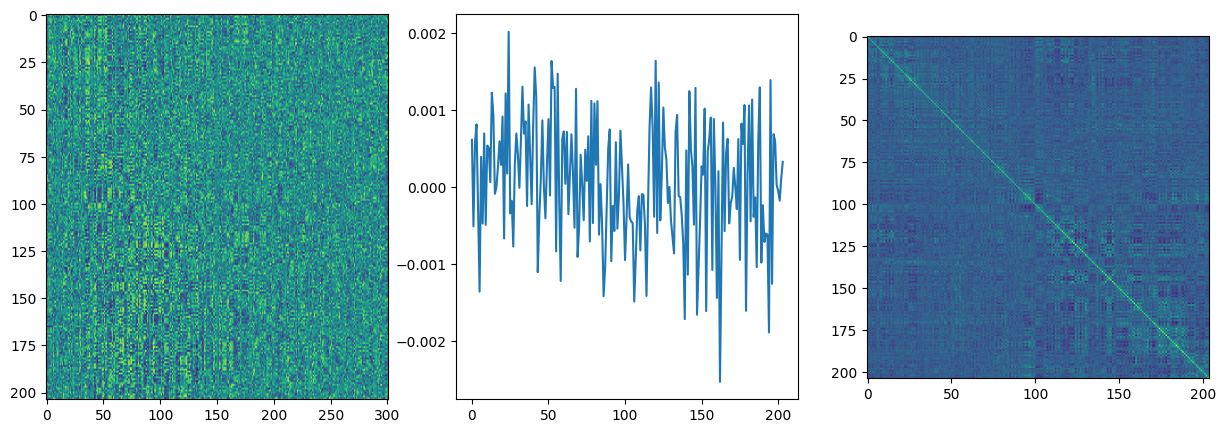

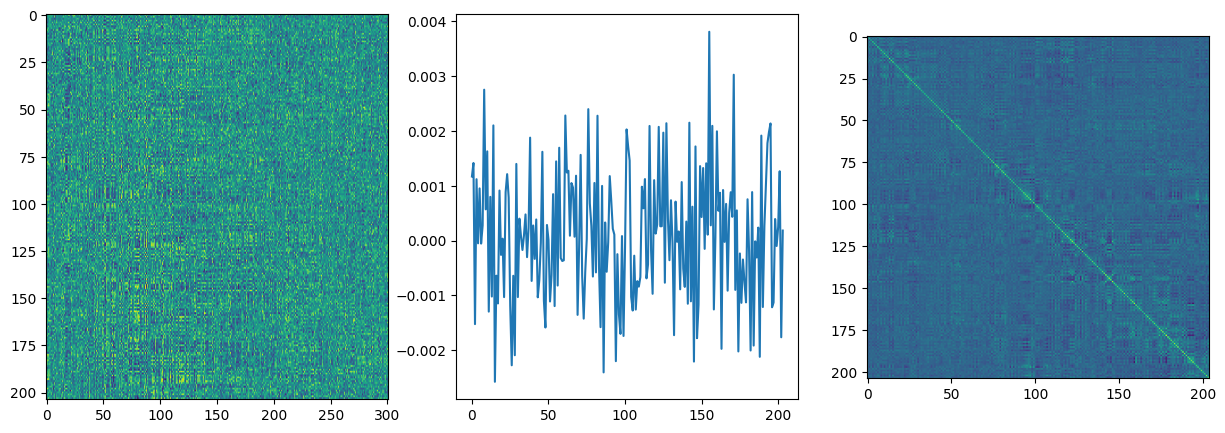

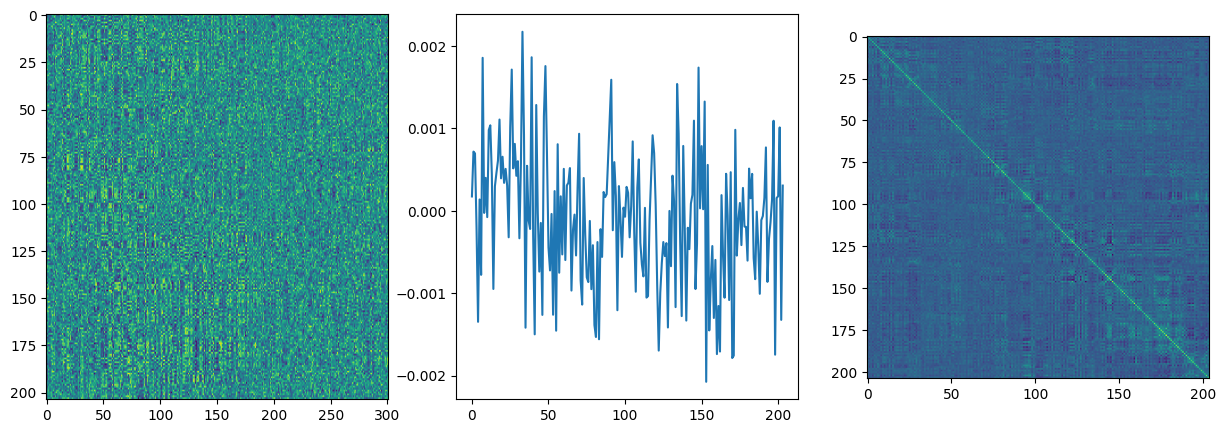

In [259]:
for n_branch in range(8):

    i = model.unmixing_layer.unmixers[n_branch].i.detach().numpy()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(i.T, aspect='auto')
    ax2.plot(i.mean(0))
    ax3.imshow(np.cov(i.T))
    plt.show()

In [58]:
x_test, y_test = next(iter(DataLoader(test, len(test))))

In [60]:
x_test.shape

torch.Size([282, 204, 301])

In [59]:
x_unmixed = model.unmixing_layer(x_test)
x_filtered = model.temp_conv(x_unmixed)

In [129]:
model.temp_conv.weight.detach()[:, 0, :].numpy().mean(-1)

array([ 0.03733407, -0.00459526,  0.01119129, -0.01430142, -0.0202    ,
       -0.00847699, -0.01730738, -0.02325396], dtype=float32)

In [64]:
x_unmixed.detach().numpy().shape

(282, 8, 301)

In [ ]:
i = int(np.random.randint(282))

for n_branch in range(8):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(x_unmixed.detach().numpy().mean(0)[n_branch])
    ax2.plot(x_unmixed.detach().numpy()[i][n_branch])
    plt.show()

3

Auditory left: 117

Auditory right: 104

Somato left: 118

Somato right: 107

Visual Lower left: 114

Visual Lower right: 129

Visual Upper left: 132

Visual Upper right: 116


In [260]:
event_dict = {
    0: 'Auditory left',
    1: 'Auditory right: ',
    2: 'Somato left: ',
    3: 'Somato right: ',
    4: 'Visual Lower left: ',
    5: 'Visual Lower right: ',
    6: 'Visual Upper left: ',
    7: 'Visual Upper right: '
}

0 Auditory left


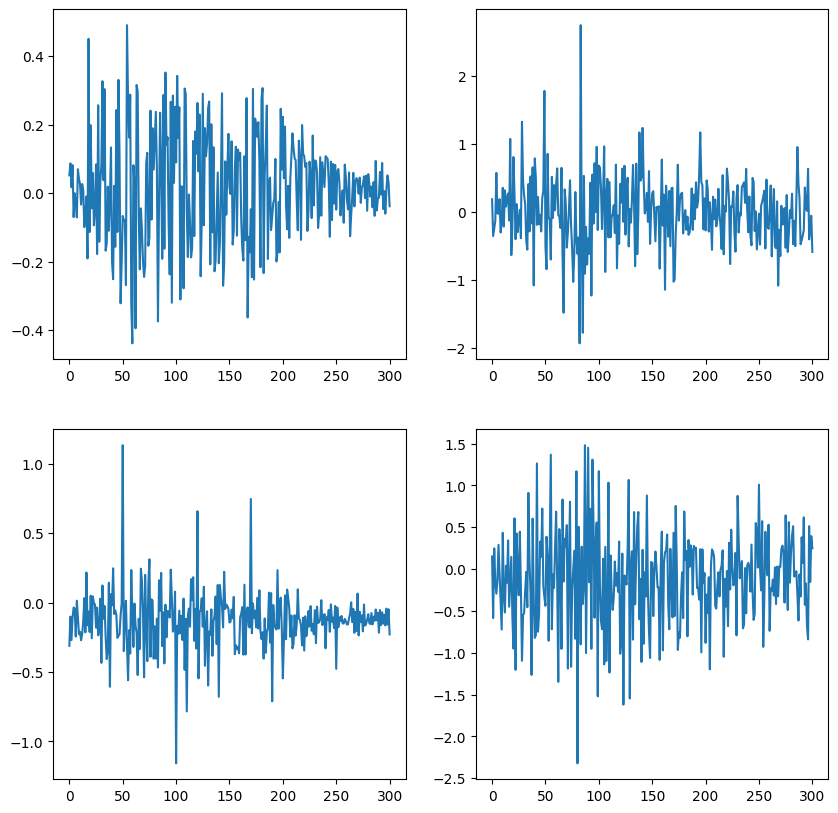

In [384]:
i = int(np.random.randint(282))
desired_event = 0
while np.where(y_test[i] == 1)[0][0] != desired_event:
    i = int(np.random.randint(282))
# for n_branch in range(1, 8):
print(np.where(y_test[i] == 1)[0][0], event_dict[desired_event])
n_branch = 7
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].plot(x_unmixed.detach().numpy().mean(0)[n_branch])
axes[0, 1].plot(x_unmixed.detach().numpy()[i][n_branch])
axes[1, 0].plot(x_filtered.detach().numpy().mean(0)[n_branch])
axes[1, 1].plot(x_filtered.detach().numpy()[i][n_branch])
plt.show()


In [400]:
@torch.no_grad()
def compute_branchwise_loss(model, dataset):
    loader = DataLoader(dataset, len(dataset))
    base_loss = model.evaluate(loader)['loss']
    n_latent = model.unmixing_layer.weight.shape[0]

    losses = list()
    for i in range(n_latent):
        branch_unmixing_weights_original = deepcopy(model.unmixing_layer.weight[i, :, :])
        model.unmixing_layer.weight[i, :, :] = 0

        if model.unmixing_layer.bias is not None:
            branch_unmixing_bias_original = deepcopy(model.unmixing_layer.bias[i])
            model.unmixing_layer.bias[i] = 0
        if model.temp_conv.bias is not None:
            branch_temp_conv_bias_original = deepcopy(model.temp_conv.bias[i])
            model.temp_conv.bias[i] = 0

        losses.append(model.evaluate(loader)['loss'])
        model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original

        if model.unmixing_layer.bias is not None:
            model.unmixing_layer.bias[i] = branch_unmixing_bias_original
        if model.temp_conv.bias is not None:
            model.temp_conv.bias[i] = branch_temp_conv_bias_original

    return base_loss - np.array(losses)

compute_branchwise_loss(model, test)

array([-0.01177645, -0.06032446, -0.10320488, -0.0128752 , -0.09452021,
       -0.11926982, -0.02151069, -0.12330705])

In [401]:
from deepmeg.interpreters import LFCNNInterpreter

In [402]:
interp = LFCNNInterpreter(model, test, info)

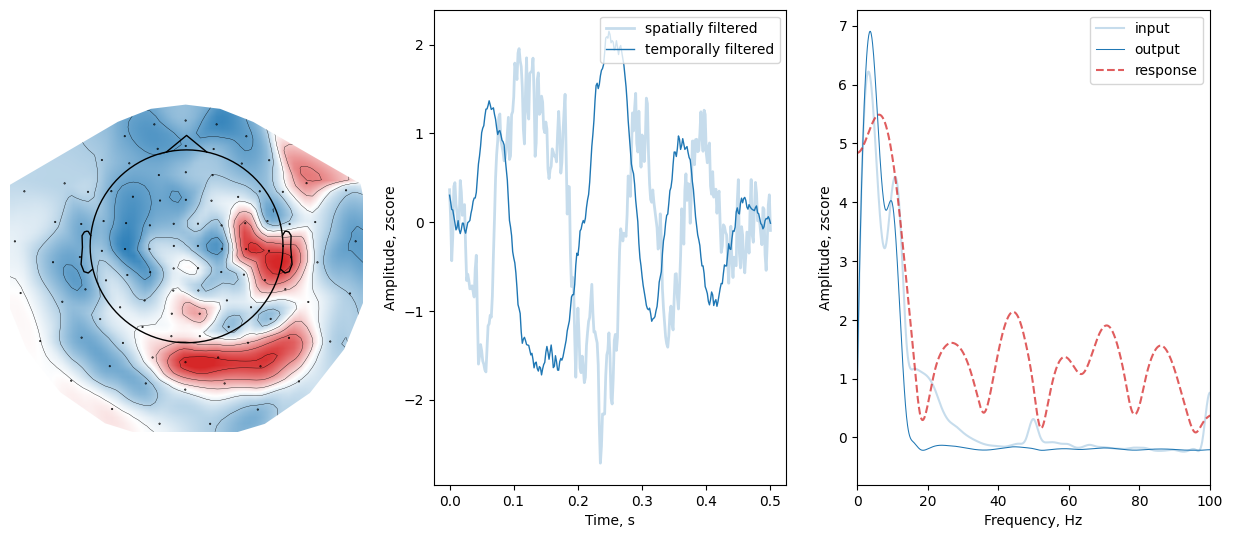

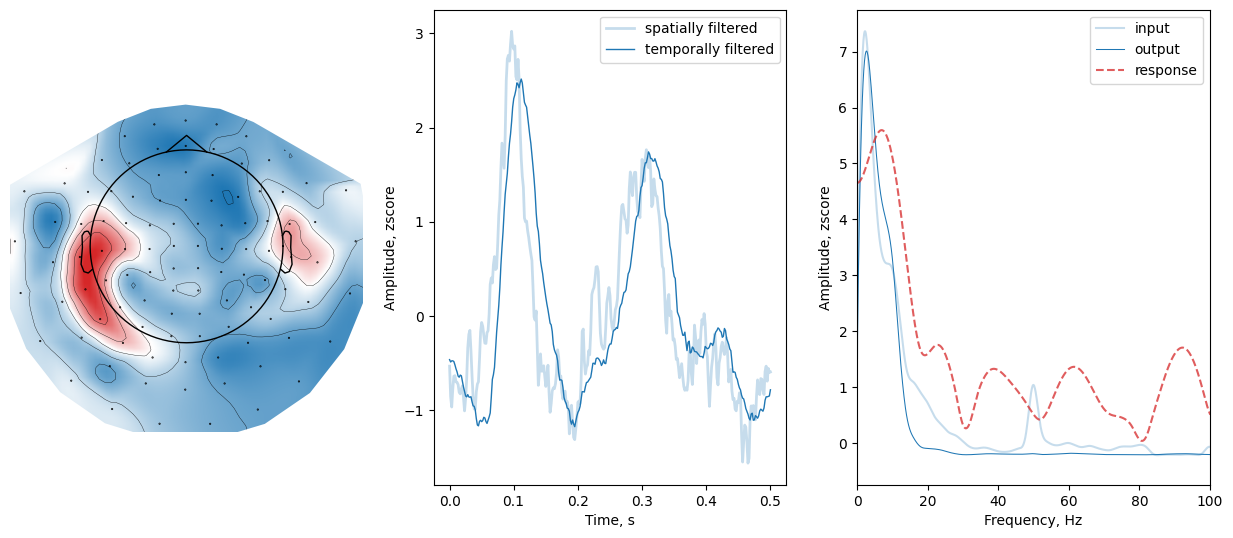

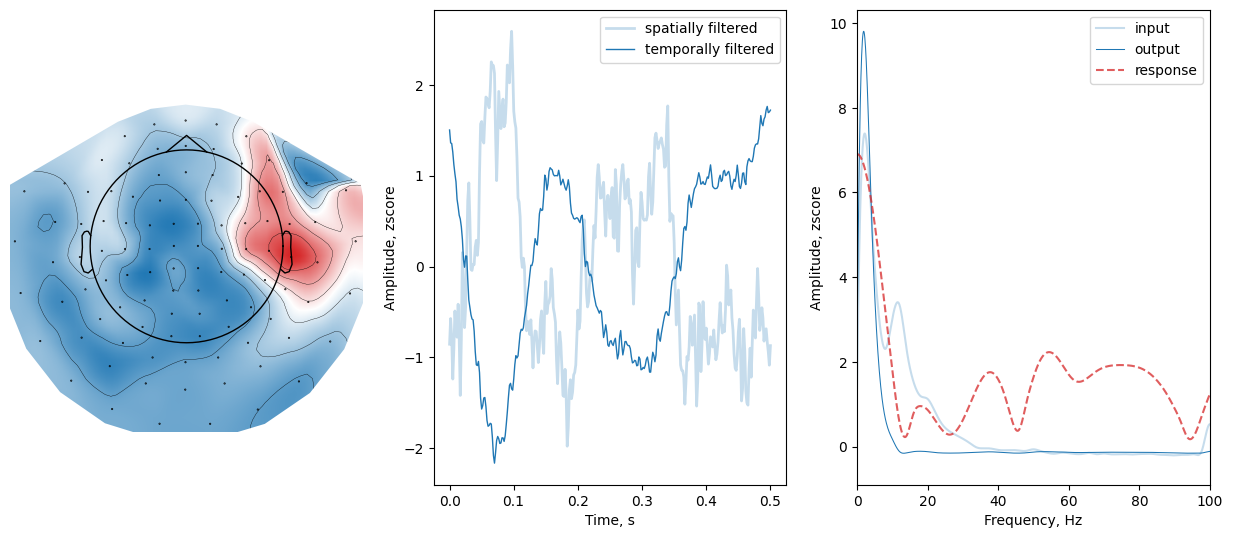

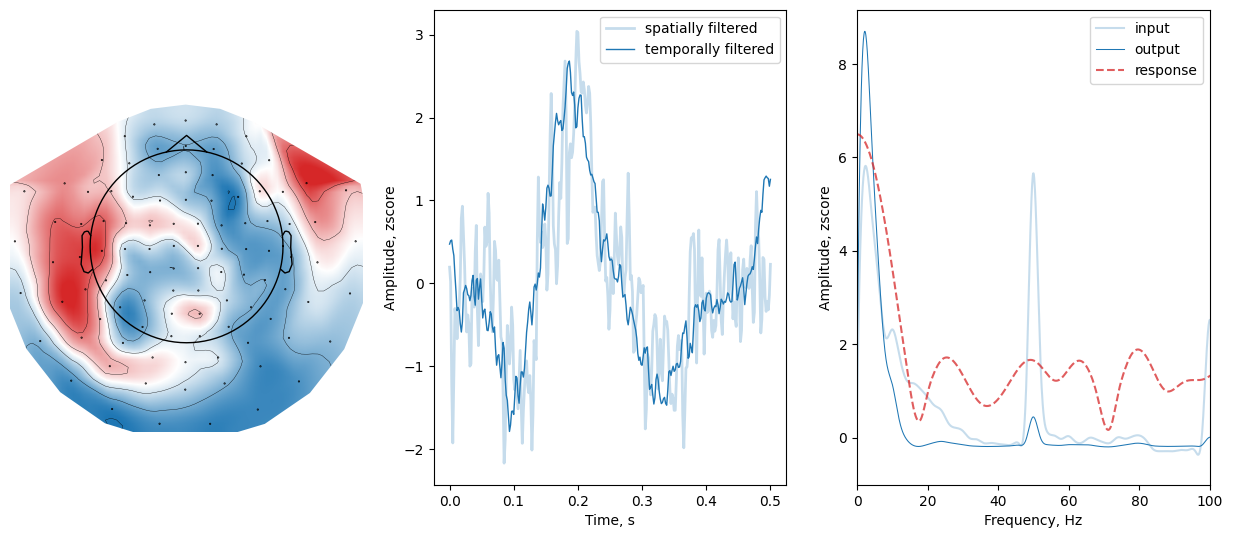

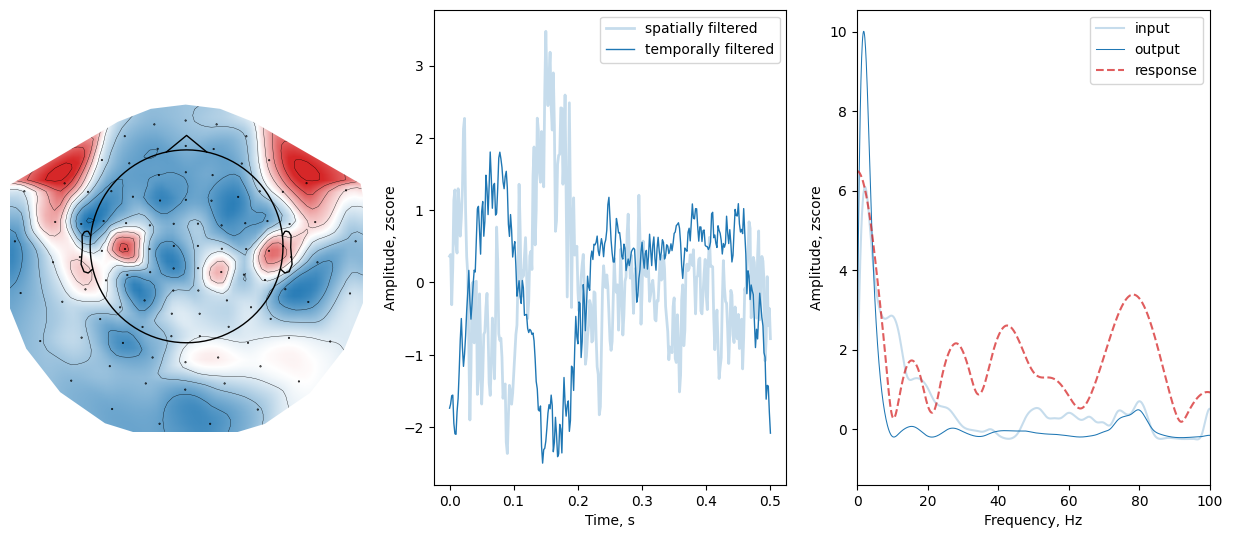

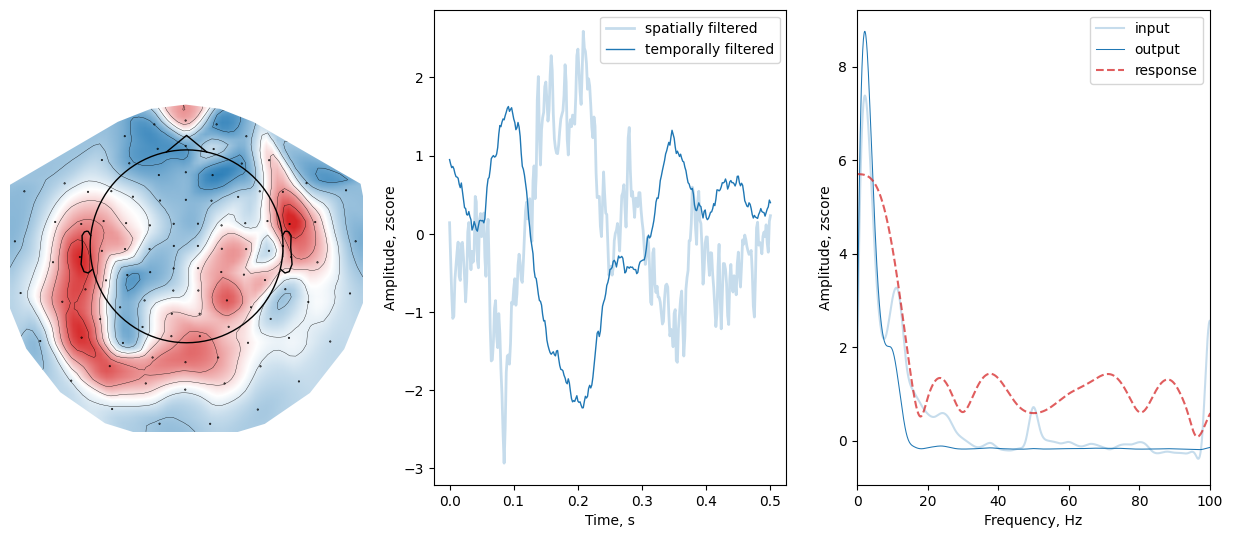

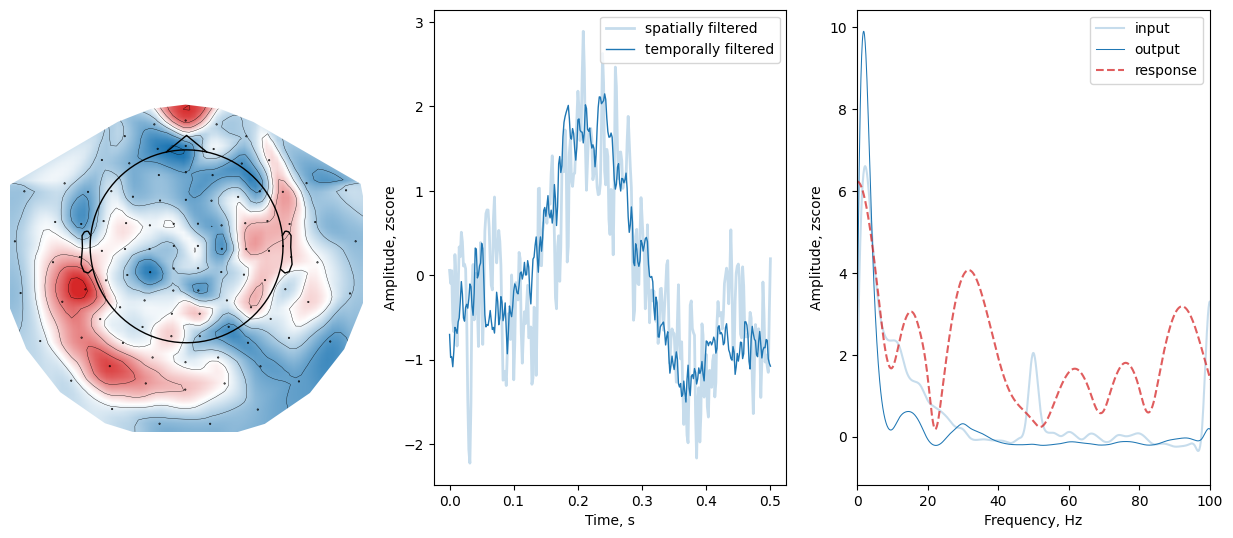

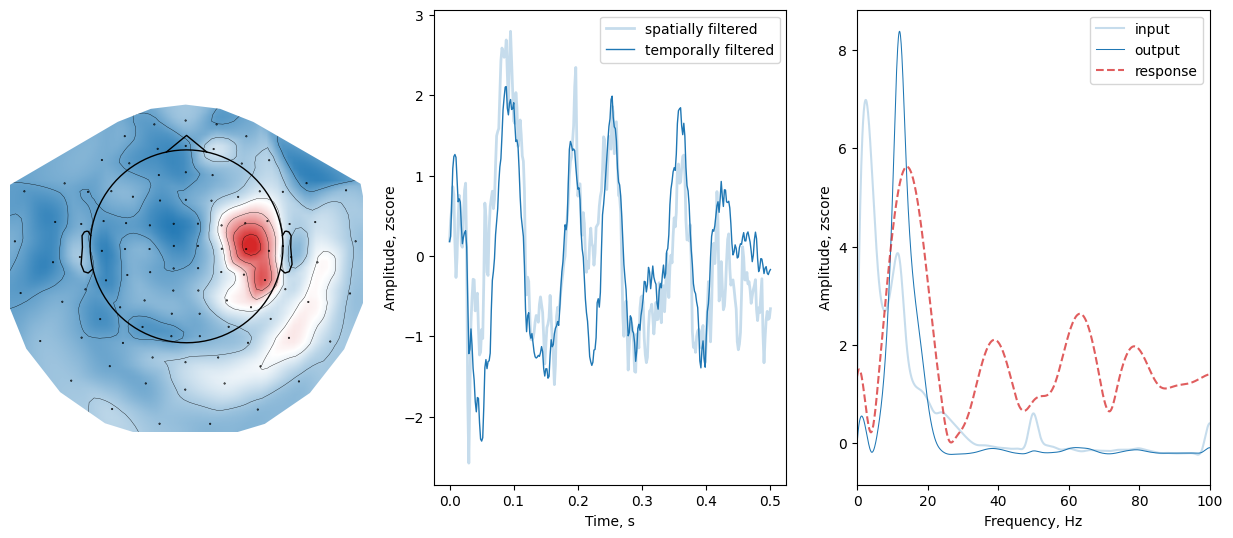

In [404]:
for i in range(8):
    interp.plot_branch(i)